# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Pre-defined Functions

In [4]:
def precision(actual, predicted):
    # Precision = True pos out of the actual results
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FP = np.count_nonzero(np.logical_and((actual == 0) , (predicted == 1)).astype(int))
    return TP/(TP + FP)

def recall(actual, predicted):
    # Recall = True pos out of the predicted results
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FN = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 0)).astype(int))
    return TP/(TP + FN)

def f_score(actual , predicted):
    P = precision(actual, predicted)
    R = recall(actual, predicted)
    return 2*P*R/(P + R)

def textPreprocess(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+',b'',text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    return text

# Data Preprocessing

In [5]:
dataFrame=pd.read_csv('/kaggle/input/fakenews-dataset/Dataset.csv')

dataFrame.dropna()
dataFrame.reset_index(inplace=True)
dataFrame = shuffle(dataFrame,random_state=20)

dataFrame.head(10)

,index,URLs,Headline,Body,Label
2992,2992,https://www.reuters.com/article/us-brazil-corr...,Brazil Olympic committee chief resigns amid br...,FILE PHOTO: President of Brazil's Olympic Comm...,1
2476,2476,https://www.reuters.com/article/us-usa-trump-e...,Eminem rebukes 'racist' Donald Trump in awards...,(Reuters) - Rapper Eminem derided U.S. Preside...,1
1515,1515,http://beforeitsnews.com/u-s-politics/2017/09/...,Racist Teacher To Student: 'Go Back Where You ...,Racist Teacher To Student: 'Go Back Where You ...,0
1389,1389,http://www.cnn.com/2017/10/11/us/california-fi...,California fires: At least 23 dead as hundreds...,"(CNN) In some areas in Sonoma County, the wild...",1
1402,1402,http://beforeitsnews.com/u-s-politics/2017/10/...,"After Alleged 'Moron' Remark, Tillerson Stroke...","Vietnam Is in Great Danger, You Must Publish a...",0
2245,2245,http://beforeitsnews.com/u-s-politics/2017/10/...,King Salman’s Favorite Golden Escalator Betray...,A Potato Battery Can Light up a Room for Over ...,0
3247,3247,https://www.nytimes.com/2017/10/07/world/europ...,"Amid Catalan Crisis, Thousands Hold Rallies in...","The vote, which had been declared illegal by t...",1
1615,1615,https://www.activistpost.com/2017/09/false-arr...,35 False Matches and 1 Erroneous Arrest As Pol...,By Nicholas West\nAll things biometric are swe...,0
2312,2312,http://beforeitsnews.com/sports/2017/09/bucs-f...,Bucs Finish Up Homestand on Winning Note 5-3,Bucs Finish Up Homestand on Winning Note 5-3\n...,0
993,993,http://beforeitsnews.com/sports/2017/09/alex-c...,Alex Collins Worth a Start?,Alex Collins Worth a Start?\n% of readers thin...,0


In [6]:
value_counts = dataFrame['Label'].value_counts()
ratio = value_counts.get(1, 0) / value_counts.get(0, 0)
print("\nFake:Real News ratio is", ratio)
dataFrame['Label'].value_counts()


Fake:Real News ratio is 0.8759943846513805


Label
0    2137
1    1872
Name: count, dtype: int64

# Text Analysis and Feature Extraction

In [7]:
stemmer = PorterStemmer()
textList = []
preprocessedText = dataFrame['Body'].apply(textPreprocess)

for text in preprocessedText:
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    textList.append(text)

# Example of the preprocessed text
print(textList[1])

reuter rapper eminem derid u presid donald trump racist reckless leader rap video air tuesday night black entertain televis hip hop award eminem told fan four minut unaccompani vocal must choos whether support presid racism thing fantast eminem rap video tape friday detroit park garag trump previous dismiss accus racism exampl said februari least racist person file photo rapper eminem perform afraid bet award lo angel june reuter mario anzuoni file photo repres white hous immedi respond request comment eminem rap one watch video youtub earli wednesday rap also mention barack obama trump predecessor white hous hillari clinton trump democrat rival last year presidenti elect file photo u rapper eminem perform abu dhabi f grand prix race close concert du arena ya island novemb reuter jumana elheloueh file photo better give obama prop caus got offic kamikaz probabl caus nuclear holocaust eminem rap eminem rebuk trump strong critic nation footbal leagu player kneel nation anthem game gestur 

In [8]:
FakeNews = dataFrame[dataFrame['Label'] == 1]
FakeNewsBody = FakeNews['Body'].apply(textPreprocess)
Text = ' '.join(FakeNewsBody.tolist())

words = word_tokenize(Text)
stop_words = set(stopwords.words('english'))
words = [word for word in words if word.lower() not in stop_words]
word_counts = Counter(words)

wordFrame = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
wordFrame.sort_values('count', ascending=False, inplace=True)
top25 = wordFrame.head(25)

# Visualisation of the 25 most frequent words in fake news
fig = go.Figure(data=[go.Bar(x=top25.index, y=top25['count'])])
fig.update_layout(title='25 Most Frequent Words in Fake News', xaxis_title='Words', yaxis_title='Frequency')
fig.show()

## TFIDF Text Vectorization and SMOTE Upsampling

In [9]:
X=dataFrame.drop('Label',axis=1)
y=dataFrame['Label']

vector=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=vector.fit_transform(textList).toarray()

print(X.shape)

(4009, 5000)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Up-sampling minority classes while avoiding overfitting by generating new synthetic examples close to the minority class in feature space.
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [11]:
# Post smote up-sampling
value_counts = y_train_resampled.value_counts()
ratio = value_counts.get(1, 0) / value_counts.get(0, 0)
print("\nFake:Real News ratio is", ratio)
y_train_resampled.value_counts()


Fake:Real News ratio is 1.0


Label
0    1509
1    1509
Name: count, dtype: int64

In [12]:
parameters = vector._get_param_names()
print
count = pd.DataFrame(X_train, columns=vector.get_feature_names_out())
count.head()

,aaron,aaron judg,aaron kesel,aaron rodger,ab,abandon,abc,abc news,abe,aberti,...,yorker,young,younger,youth,youtub,zach,zapatista,zealand,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.07461,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.048286,0.503343,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.026363,0.0,0.0,0.0,0.0,0.0


# Training models

## Ensemble Learning - 1

In [ ]:
# Base models
model1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model2 = GaussianNB()
model3 = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Max voting ensemble with soft voting
ensemble_model1 = VotingClassifier(
    estimators=[
        ('xgb', model1),
        ('nb', model2),
        ('rf', model3)
    ],
    voting='soft'
)

ensemble_model1.fit(X_train_resampled, y_train_resampled)
y_pred = ensemble_model1.predict(X_test)

Accuracy: 0.98

F-score: 0.98

Precision: 0.97

Recall: 0.99


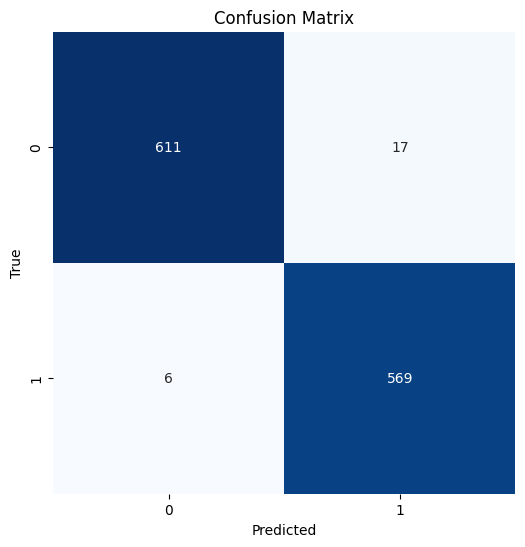

In [ ]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
fscore = f_score(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Ensemble Learning - 2

In [ ]:
# Base models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [ ]:
# Max voting ensemble with soft voting
ensemble_model2 = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('gb', gb_model)
    ],
    voting='soft'
)

ensemble_model2.fit(X_train_resampled, y_train_resampled)
y_pred2 = ensemble_model2.predict(X_test)

Accuracy: 0.99

F-score: 0.99

Precision: 0.99

Recall: 0.99


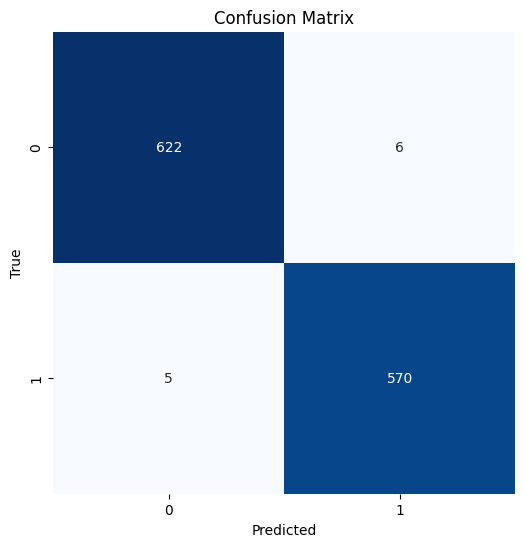

In [ ]:
#Evaluation metrics
accuracy = accuracy_score(y_test, y_pred2)
fscore = f_score(y_test, y_pred2)
prec = precision(y_test, y_pred2)
rec = recall(y_test, y_pred2)
conf_m = confusion_matrix(y_test, y_pred2)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### Better ensemble model with Logistic Regression + Random Forest + Gradient Boosting

# Hyperparameter Tuning for 2nd Model

In [23]:
# Base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

## Bayesian Optimisation for RF

In [ ]:
# Function to return negative RMSE
def optimizationRF(n_estimators, max_depth, min_samples_split, max_features):
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  max_features=min(max_features, 0.999),
                                  random_state=42)

    return -1.0 * cross_val_score(model, X_train_resampled, y_train_resampled, cv=3, scoring="neg_mean_squared_error").mean()

# Hyperparameters to optimise
param_boundsRF = {
    'n_estimators': (10, 250),
    'max_depth': (1, 50),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999),
}

optimizerRF = BayesianOptimization(f=optimizationRF, pbounds=param_boundsRF, random_state=42)
optimizerRF.maximize(init_points=5, n_iter=15)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |

-------------------------------------------------------------------------

| 1         | 0.04175   | 19.35     | 0.9547    | 18.84     | 153.7     |

| 2         | 0.03413   | 8.645     | 0.2402    | 3.336     | 217.9     |

| 3         | 0.03645   | 30.45     | 0.7366    | 2.473     | 242.8     |

| 4         | 0.02916   | 41.79     | 0.2909    | 6.182     | 54.02     |

| 5         | 0.03877   | 15.91     | 0.5718    | 11.93     | 79.89     |

| 6         | 0.03115   | 20.09     | 0.4191    | 18.76     | 153.5     |

| 7         | 0.08648   | 3.412     | 0.1166    | 15.81     | 183.7     |

| 8         | 0.08217   | 3.784     | 0.1       | 15.13     | 182.6     |

| 9         | 0.06594   | 5.972     | 0.5506    | 15.86     | 185.4     |

| 10        | 0.217     | 1.135     | 0.4694    | 15.51     | 185.9     |

| 11        | 0.1471    | 2.295     | 0.5123    | 13.45     | 186.4     |

| 12        | 0.224     |

In [ ]:
# Best hyperparameters
best_params = optimizerRF.max['params']
print("Best Parameters for RF:", best_params)

# New RandomForestClassifier model with the best hyperparameters
rf_best = RandomForestClassifier(n_estimators=int(best_params['n_estimators']),
                                   max_depth=int(best_params['max_depth']),
                                   min_samples_split=int(best_params['min_samples_split']),
                                   max_features=best_params['max_features'],
                                   random_state=42)

Best Parameters for RF: {'max_depth': 1.629465525941345, 'max_features': 0.16687546655408142, 'min_samples_split': 20.827521435128666, 'n_estimators': 197.67469510524577}


## Bayesian Optimisation for GB

In [ ]:
from sklearn.metrics import make_scorer
score = make_scorer(accuracy_score)

def optimizationGB(max_depth, max_features, learning_rate, n_estimators, subsample):
    params_gb = {}
    params_gb['max_depth'] = round(max_depth)
    params_gb['max_features'] = max_features
    params_gb['learning_rate'] = learning_rate
    params_gb['n_estimators'] = round(n_estimators)
    params_gb['subsample'] = subsample

    return (cross_val_score(GradientBoostingClassifier(random_state=42, **params_gb),
                             X_train_resampled, y_train_resampled, scoring=score, cv=5).mean()).mean()

params_gb ={
    'max_depth':(3, 10),
    'max_features':(0.8, 1),
    'learning_rate':(0.01, 1),
    'n_estimators':(80, 150),
    'subsample': (0.8, 1)
}

optimiserGB = BayesianOptimization(optimizationGB, params_gb, random_state=111)
optimiserGB.maximize(init_points=20, n_iter=4)

|   iter    |  target   | learni... | max_depth | max_fe... | n_esti... | subsample |

-------------------------------------------------------------------------------------

| 1         | 0.9771    | 0.616     | 4.183     | 0.8872    | 133.8     | 0.8591    |

| 2         | 0.9728    | 0.1577    | 3.157     | 0.884     | 96.71     | 0.8675    |

| 3         | 0.9722    | 0.9908    | 4.664     | 0.8162    | 126.9     | 0.9242    |

| 4         | 0.9745    | 0.2815    | 6.264     | 0.8237    | 85.18     | 0.9802    |

| 5         | 0.9718    | 0.796     | 8.884     | 0.963     | 149.4     | 0.9155    |

| 6         | 0.9748    | 0.8156    | 5.949     | 0.8055    | 111.8     | 0.8211    |

| 7         | 0.9768    | 0.819     | 7.884     | 0.9131    | 99.2      | 0.9997    |

| 8         | 0.9728    | 0.1467    | 7.308     | 0.897     | 108.4     | 0.9456    |

| 9         | 0.9765    | 0.3296    | 5.804     | 0.8638    | 146.3     | 0.9837    |

| 10        | 0.9732    | 0.8157    | 3.239

In [ ]:
# Best hyperparameters
best_params = optimiserGB.max['params']
best_params['max_depth'] = round(best_params['max_depth'])
best_params['n_estimators'] = round(best_params['n_estimators'])
print("Best Parameters for GB:", best_params)

# New GradientBoostingClassifier model with the best hyperparameters
gb_best = GradientBoostingClassifier(n_estimators=int(best_params['n_estimators']),
                                max_depth=int(best_params['max_depth']),
                                subsample=best_params['subsample'],
                                max_features=best_params['max_depth'],
                                learning_rate=best_params['learning_rate'],
                                random_state=42)

Best Parameters for GB: {'learning_rate': 0.494927115019697, 'max_depth': 7, 'max_features': 0.833799281707321, 'n_estimators': 143, 'subsample': 0.9337483086427925}


## Bayesian Optimisation for LR

In [ ]:
# Function to return negative RMSE
def optimizationLR(C, penalty, class_weight):
    penalty = 'l1' if penalty < 0.5 else 'l2'
    class_weight = 'balanced' if class_weight >= 0.5 else None
    model = LogisticRegression(C=C,
                            penalty=penalty,
                            class_weight=class_weight,
                            solver='liblinear',
                            random_state=42)

    return cross_val_score(model, X_train_resampled, y_train_resampled, cv=3, scoring="neg_mean_squared_error").mean()

# Hyperparameters to optimise
param_boundsLR = {
      'C': (0.001, 100),
      'penalty': (0, 1),
      'class_weight': (0, 1)
}
optimizerLR = BayesianOptimization(f=optimizationLR, pbounds=param_boundsLR, random_state=42)
optimizerLR.maximize(init_points=5, n_iter=15)

|   iter    |  target   |     C     | class_... |  penalty  |

-------------------------------------------------------------

| 1         | -0.02253  | 37.45     | 0.9507    | 0.732     |

| 2         | -0.02618  | 59.87     | 0.156     | 0.156     |

| 3         | -0.02253  | 5.809     | 0.8662    | 0.6011    |

| 4         | -0.02253  | 70.81     | 0.02058   | 0.9699    |

| 5         | -0.02551  | 83.24     | 0.2123    | 0.1818    |

| 6         | -0.02253  | 70.76     | 0.04546   | 0.8386    |

| 7         | -0.0222   | 29.2      | 0.9924    | 0.737     |

| 8         | -0.02054  | 18.91     | 0.9771    | 0.5203    |

| 9         | -0.02154  | 13.78     | 0.02143   | 0.8402    |

| 10        | -0.02253  | 100.0     | 1.0       | 1.0       |

| 11        | -0.02717  | 22.89     | 0.0       | 0.0       |

| 12        | -0.02154  | 16.81     | 0.8305    | 0.7695    |

| 13        | -0.02121  | 10.74     | 0.8117    | 0.5495    |

| 14        | -0.0222   | 32.96     | 0.01429   | 0.955

In [ ]:
# Best hyperparameters
best_params = optimizerLR.max['params']
best_params['class_weight'] = 'balanced' if best_params['class_weight'] >= 0.5 else None
best_params['penalty'] = 'l1' if best_params['penalty'] < 0.5 else 'l2'
print("Best Parameters for LG:", best_params)

# New LogisticRegression model with the best hyperparameters
lr_best = LogisticRegression(C=best_params['C'],
                             penalty=best_params['penalty'],
                             class_weight=best_params['class_weight'],
                             solver='liblinear',
                             random_state=42)

Best Parameters for LG: {'C': 18.90777121832313, 'class_weight': 'balanced', 'penalty': 'l2'}


## Optimised Ensemble Model

In [13]:
# Max voting ensemble with soft voting
rf_best = RandomForestClassifier(n_estimators=197,
                                   max_depth=1,
                                   min_samples_split=20,
                                   max_features=0.16687546655408142,
                                   random_state=42)

gb_best = GradientBoostingClassifier(n_estimators=143,
                                max_depth=7,
                                subsample=0.9337483086427925,
                                max_features=0.833799281707321,
                                learning_rate=0.494927115019697,
                                random_state=42)

lr_best = LogisticRegression(C=18.90777121832313,
                             penalty='l2',
                             class_weight='balanced',
                             solver='liblinear',
                             random_state=42)


optimisedModel = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('lr', lr_best),
        ('gb', gb_best)
    ],
    voting='soft'
)

optimisedModel.fit(X_train_resampled, y_train_resampled)
y_pred = optimisedModel.predict(X_test)

Accuracy: 0.99
F-score: 0.98
Precision: 0.99
Recall: 0.98


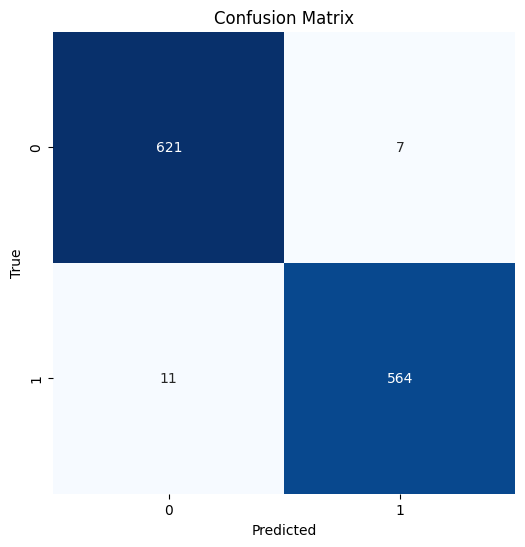

In [14]:
#Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
fscore = f_score(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Credibility Scoring and News Testing

In [68]:
def outputLabel(n):
    if n==0:
        return "Fake News"
    elif n==1:
        return "Not Fake News"

def Testing(news):
    testing_news = {"Body":[news]}
    newsFrame = pd.DataFrame(testing_news)
    stemmer = PorterStemmer()
    preprocessedText = newsFrame["Body"].apply(textPreprocess)
    textList = []
    for text in preprocessedText:
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]
        text = ' '.join(text)
        textList.append(text)
    test=vector.transform(preprocessedText)
    testPred = optimisedModel.predict(test)
    
    # Credibility Score: Likelihood of news article being real (not fake)
    probability = optimisedModel.predict_proba(test)[:, 1]
    credibilityScore = 1 / (1 + np.exp(-probability))
    
    return print("\n\nPrediction: {} \nCredibility Score: {}".format(
        outputLabel(testPred),
        f"{credibilityScore[0]:.2f}"
    ))

In [69]:
news = str(input()) 
Testing(news)

# Fake news
# JetNation FanDuel League; Week 4 of readers think this story is Fact. Add your two cents.
# (Before Its News)Our FanDuel league is back again this week. Here are the details:$900 in 
# total prize money. $250 to the winner. $10 to enter.Remember this is a one week league, 
# pick your lineup against the salary cap and next week if you want to play again you can 
# pick a completely different lineup if you want.Click this link to enter — http://fanduel.
# com/JetNation You can discuss this with other NY Jets fans on the Jet Nation message board. 
# Or visit of on  Facebook.Source: http://www.jetnation.com/2017/09/27/jetnation-fanduel-
# league-week-4/

  JetNation FanDuel League; Week 4 of readers think this story is Fact. Add your two cents.(Before Its News)Our FanDuel league is back again this week. Here are the details:$900 in total prize money. $250 to the winner. $10 to enter.Remember this is a one week league, pick your lineup against the salary cap and next week if you want to play again you can pick a completely different lineup if you want.Click this link to enter — http://fanduel.com/JetNation You can discuss this with other NY Jets fans on the Jet Nation message board. Or visit of on Facebook.Source: http://www.jetnation.com/2017/09/27/jetnation-fanduel-league-week-4/




Prediction: Fake News 
Credibility Score: 0.52


In [70]:
news = str(input()) 
Testing(news)

# Real News
#"""The second Covid-19 wave in India is now on the "downswing," the Centre said on Thursday, 
#highlighting that the current number of active cases is still "very high" and advised states 
#and Union territories (UTs) to not let down their guards."

  """The second Covid-19 wave in India is now on the "downswing," the Centre said on Thursday, highlighting that the current number of active cases is still "very high" and advised states and Union territories (UTs) to not let down their guards."""




Prediction: Not Fake News 
Credibility Score: 0.70


In [71]:
news = str(input()) 
Testing(news)

# Real News
# 'U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this 
# week, amid criticism that no top American officials attended Sundayâ€™s unity march against 
# terrorism.'

  'U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sundayâ€™s unity march against terrorism.'




Prediction: Not Fake News 
Credibility Score: 0.70


# Deployment

In [2]:
pip install modelbit

INFO: pip is looking at multiple versions of types-requests to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of types-requests to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.1/135.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 68.4 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.106
    Uninstalling botocore-1.34.106:
      Successfully uninstalled botocore-1.34.106
ERROR: pip's dependency resolv

In [3]:
import modelbit
mb = modelbit.login()